In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yfinance as yf
import pandas as pd 

tickers = ['SPY', 'MSFT', 'AAPL', 'GOOG', 'AMZN', 'TSLA', 'NVDA', 'META', 'ILMN', 'NFLX'] 
df = yf.download(tickers, start = '2018-01-01', end = '2024-12-31', interval='1mo') # use monthly prices
df.head()

[*********************100%%**********************]  10 of 10 completed


Price       Adj Close                                                \
Ticker           AAPL       AMZN       GOOG        ILMN        META   
Date                                                                  
2018-01-01  39.477062  72.544502  58.430511  226.303497  186.506729   
2018-02-01  41.997578  75.622498  55.173714  221.809341  177.954330   
2018-03-01  39.720867  72.366997  51.530861  229.980545  159.462311   
2018-04-01  39.124279  78.306503  50.808681  234.367706  171.647278   
2018-05-01  44.240307  81.481003  54.187836  265.019470  191.386719   

Price                                                               ...  \
Ticker           MSFT        NFLX      NVDA         SPY       TSLA  ...   
Date                                                                ...   
2018-01-01  88.362885  270.299988  6.079518  253.339905  23.620667  ...   
2018-02-01  87.209625  291.380005  5.985530  244.128311  22.870667  ...   
2018-03-01  85.283295  295.350006  5.731614  236.489487  17.742001  ...   
2018-04-01  87.385689  312.459991  5.566042  238.663788  19.593332  ...   
2018-05-01  92.356728  351.600006  6.241442  244.465500  18.982000  ...   

Price           Volume                                                         \
Ticker            AAPL        AMZN       GOOG      ILMN       META       MSFT   
Date                                                                            
2018-01-01  2638717600  1927424000  574768000  21953865  495655700  574258400   
2018-02-01  3711577200  2755680000  847640000  18582845  516251600  725663300   
2018-03-01  2854910800  2608002000  907066000  16350441  996201700  750754800   
2018-04-01  2664617200  2598392000  834318000  20809187  750072700  668130700   
2018-05-01  2483905200  1432310000  636988000  15387515  401144100  509417900   

Price                                                       
Ticker           NFLX         NVDA         SPY        TSLA  
Date                                                        
2018-01-01  238377600  11456216000  1985506700  1864072500  
2018-02-01  184585800  14915528000  2923722000  1637850000  
2018-03-01  263449400  14118440000  2323561800  2359027500  
2018-04-01  262006000  11144008000  1998466500  2854662000  
2018-05-01  142050800  11978240000  1606397200  2333671500  

[5 rows x 60 columns]

In [3]:
df = df.loc[:, (['Adj Close'], tickers)]
df.columns = df.columns.droplevel() # drop MultiIndex
df = df.reset_index()
df.head()

Ticker,Date,SPY,MSFT,AAPL,GOOG,AMZN,TSLA,NVDA,META,ILMN,NFLX
0,2018-01-01,253.339905,88.362885,39.477062,58.430511,72.544502,23.620667,6.079518,186.506729,226.303497,270.299988
1,2018-02-01,244.128311,87.209625,41.997578,55.173714,75.622498,22.870667,5.985530,177.954330,221.809341,291.380005
2,2018-03-01,236.489487,85.283295,39.720867,51.530861,72.366997,17.742001,5.731614,159.462311,229.980545,295.350006
3,2018-04-01,238.663788,87.385689,39.124279,50.808681,78.306503,19.593332,5.566042,171.647278,234.367706,312.459991
4,2018-05-01,244.465500,92.356728,44.240307,54.187836,81.481003,18.982000,6.241442,191.386719,265.019470,351.600006


In [4]:
prices = df.melt(id_vars = 'Date')
prices = prices.rename(columns={'Date': 'ds', 'Ticker': 'unique_id', 'value': 'y'})
prices = prices[['unique_id', 'ds', 'y']]
prices

,unique_id,ds,y
0,SPY,2018-01-01,253.339905
1,SPY,2018-02-01,244.128311
2,SPY,2018-03-01,236.489487
3,SPY,2018-04-01,238.663788
4,SPY,2018-05-01,244.465500
...,...,...,...
795,NFLX,2024-04-01,550.640015
796,NFLX,2024-05-01,641.619995
797,NFLX,2024-06-01,674.880005
798,NFLX,2024-07-01,628.349976


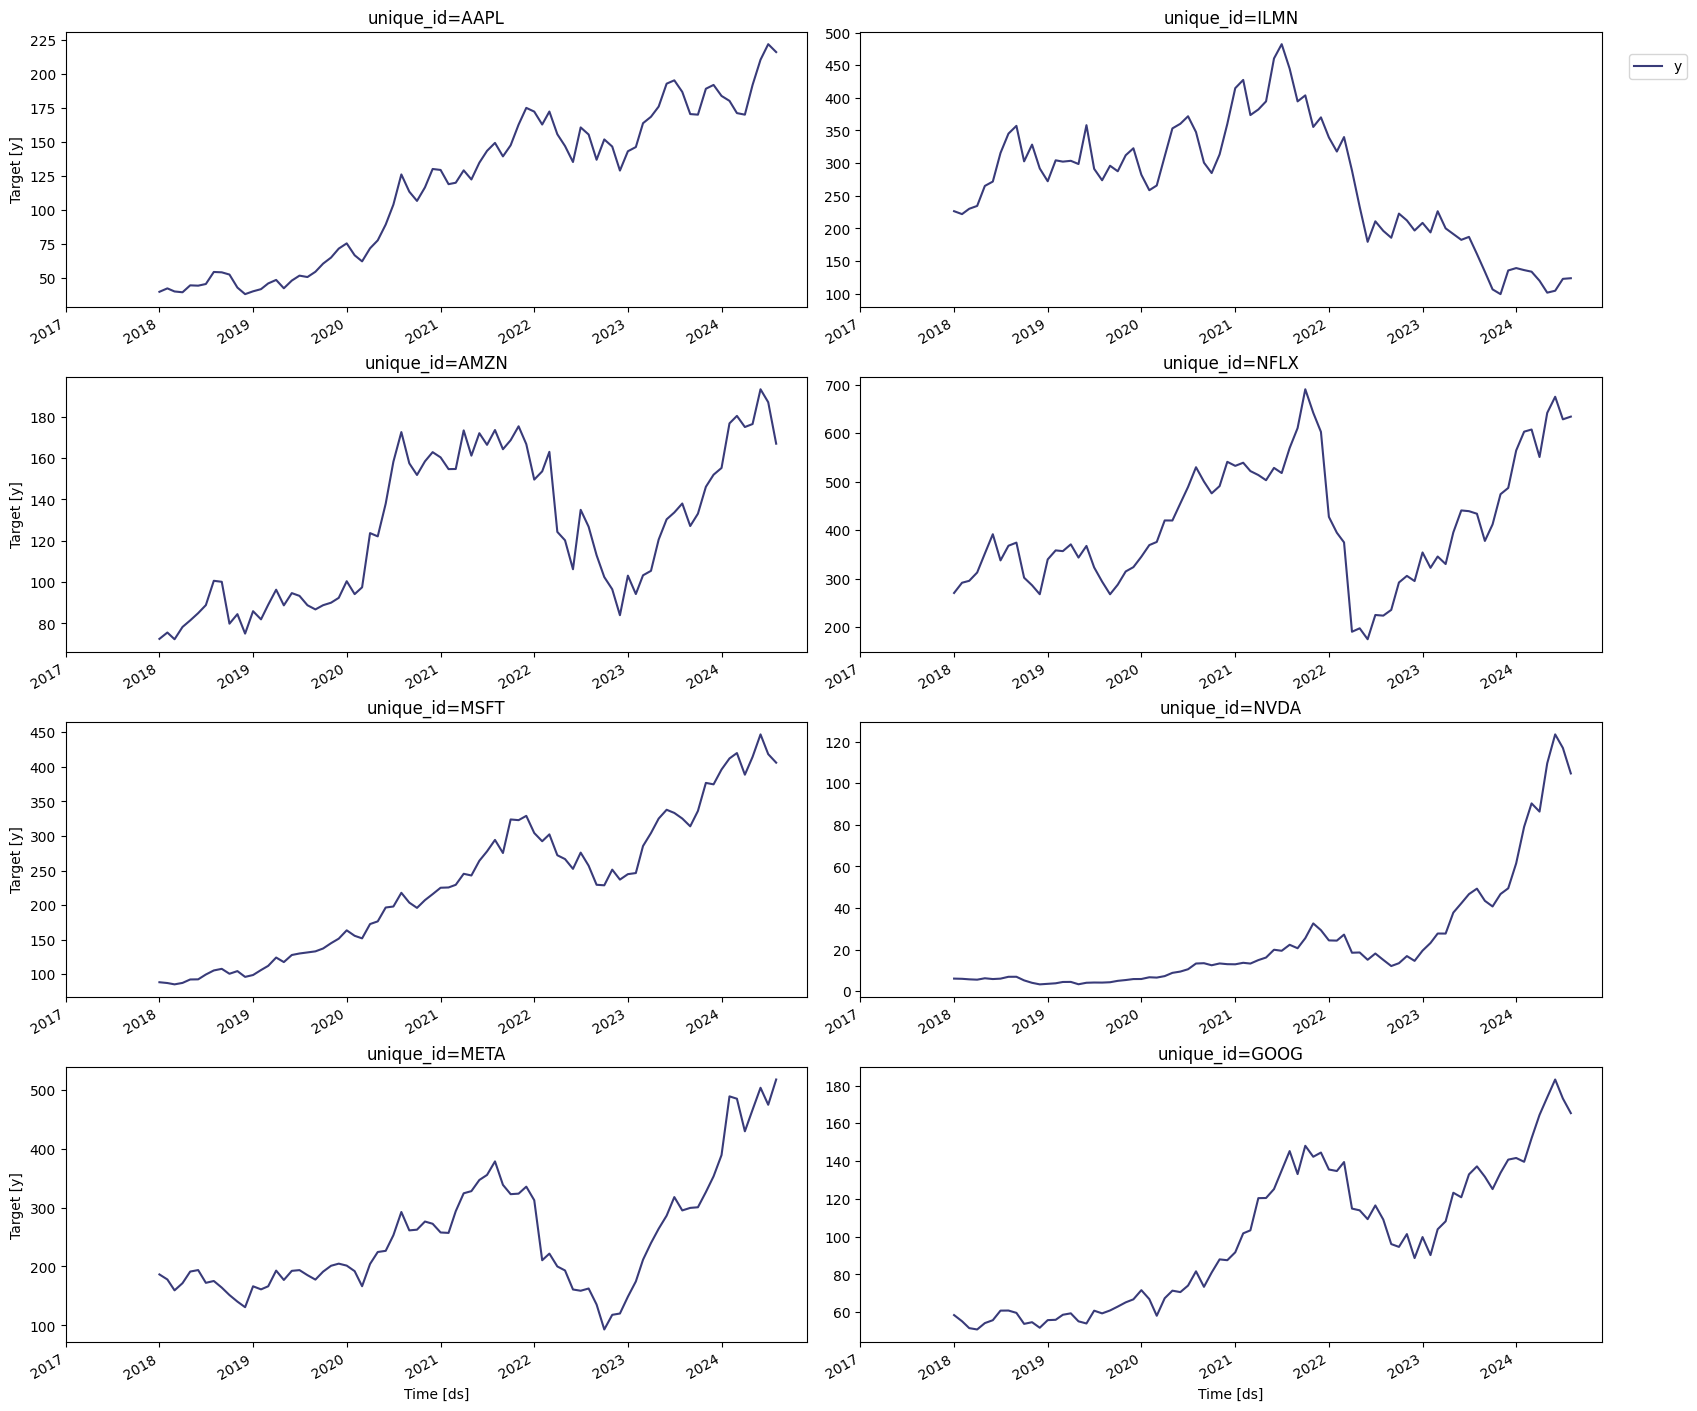

In [5]:
from statsforecast import StatsForecast
StatsForecast.plot(prices)

With the prices, we can compute the logarithmic returns of the S&P 500 and the publicly traded companies. This is the variable we’re interested in since it’s likely to work well with the GARCH framework. The logarithmic return is given by

$return_t = log(price_t/price_(t-1))$

We’ll compute the returns on the price dataframe and then we’ll create a return dataframe with StatsForecast’s format. To do this, we’ll need numpy.

In [6]:
import numpy as np 
prices['rt'] = prices['y'].div(prices.groupby('unique_id')['y'].shift(1))
prices['rt'] = np.log(prices['rt'])

returns = prices[['unique_id', 'ds', 'rt']]
returns = returns.rename(columns={'rt':'y'})
returns

,unique_id,ds,y
0,SPY,2018-01-01,NaN
1,SPY,2018-02-01,-0.037038
2,SPY,2018-03-01,-0.031790
3,SPY,2018-04-01,0.009152
4,SPY,2018-05-01,0.024018
...,...,...,...
795,NFLX,2024-04-01,-0.097991
796,NFLX,2024-05-01,0.152915
797,NFLX,2024-06-01,0.050539
798,NFLX,2024-07-01,-0.071438


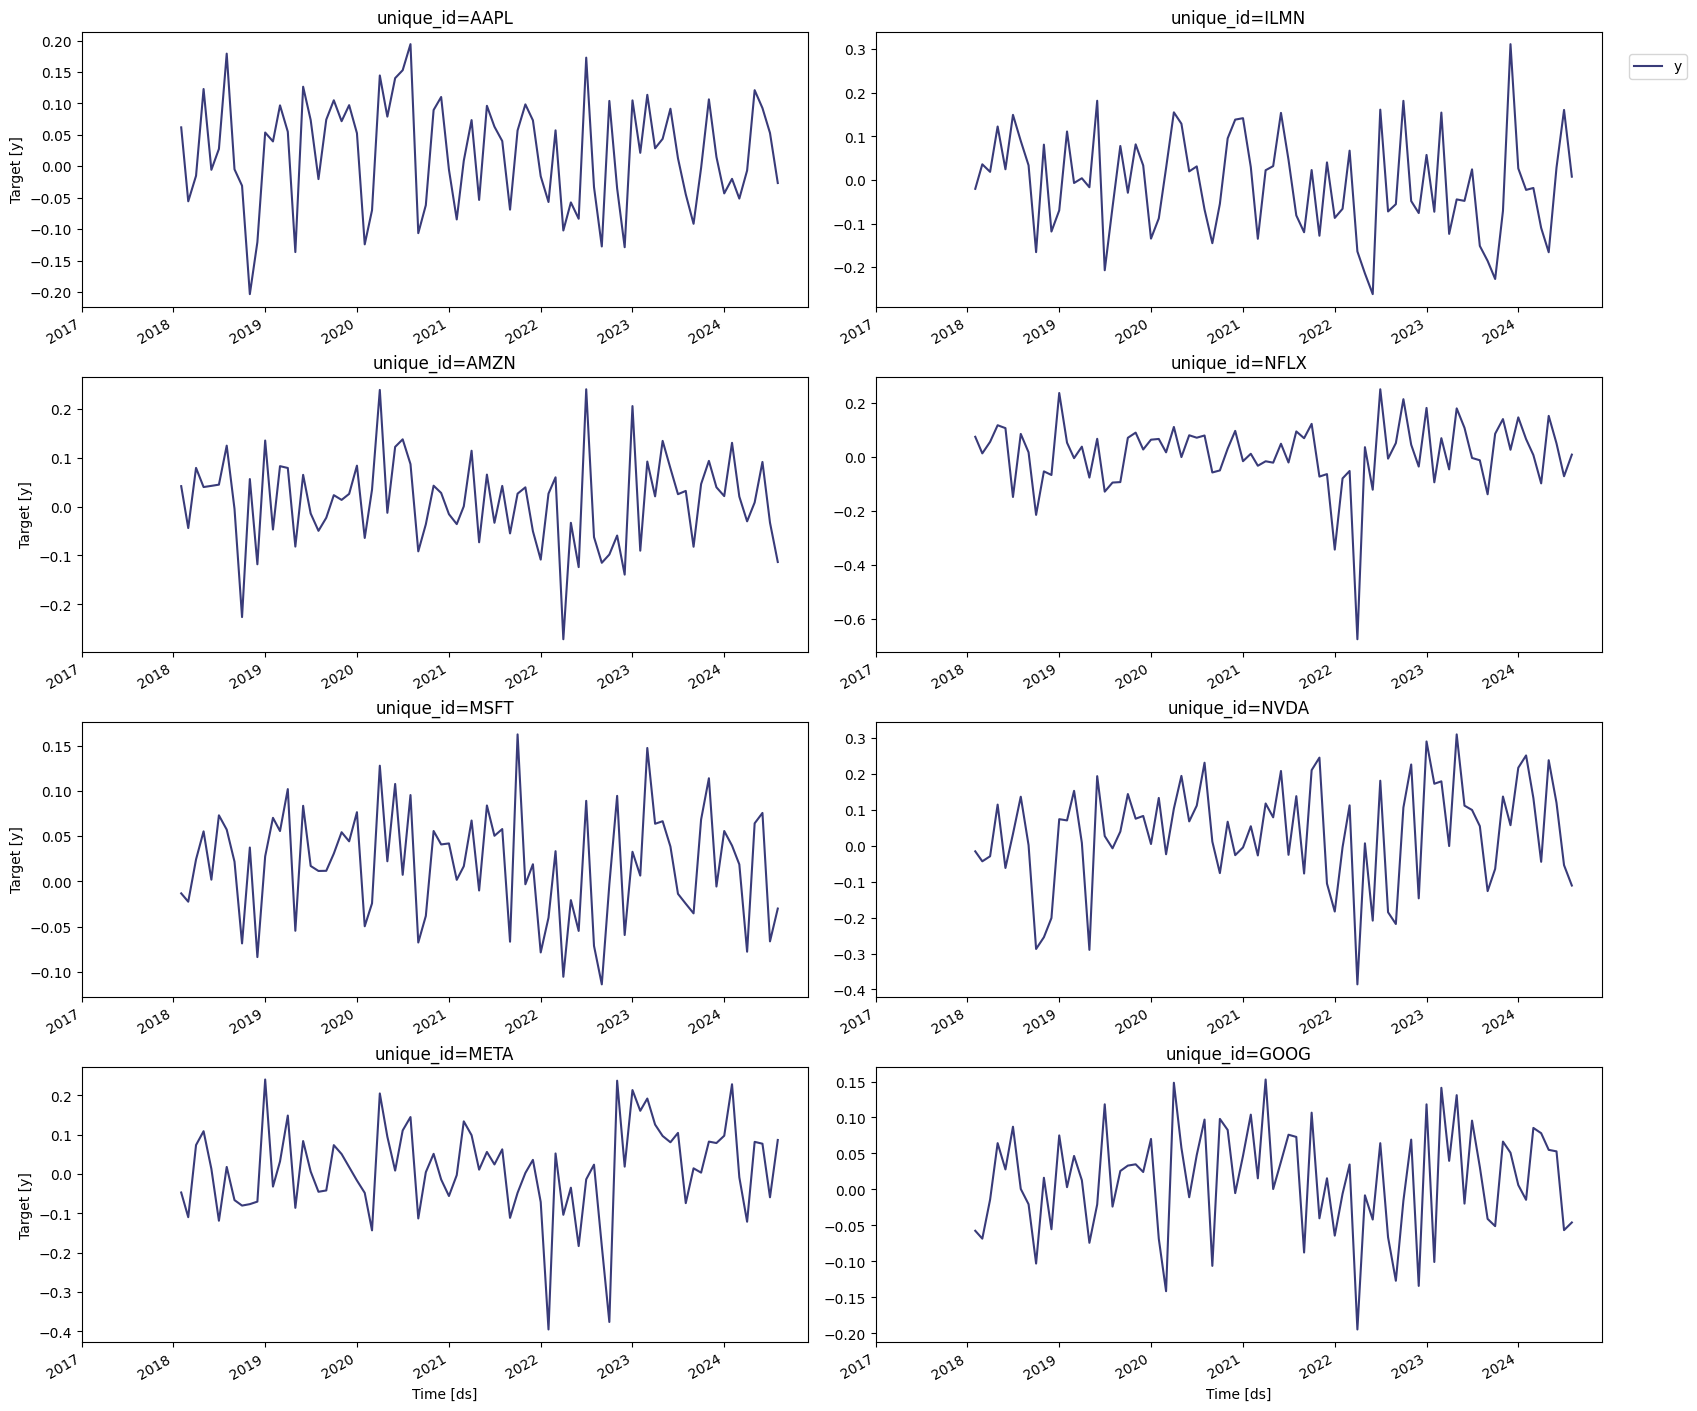

In [7]:
StatsForecast.plot(returns)

In [8]:
from statsforecast.models import (
    GARCH, 
    ARCH, 
    Naive
)

models = [ARCH(1), 
          ARCH(2), 
          GARCH(1,1),
          GARCH(1,2),
          GARCH(2,2),
          GARCH(2,1),
          Naive()
]

In [9]:
sf = StatsForecast(
    df = returns, 
    models = models, 
    freq = 'MS',
    n_jobs = -1
)

/opt/anaconda3/envs/llm/lib/python3.12/site-packages/statsforecast/core.py:474: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


Time series cross-validation is a method for evaluating how a model would have performed in the past. It works by defining a sliding window across the historical data and predicting the period following it. Here we’ll use StatsForercast’s cross-validation method to determine the most accurate model for the S&P 500 and the companies selected.

This method takes the following arguments:

- df: The dataframe with the training data.
- h (int): represents the h steps into the future that will be forecasted.
- step_size (int): step size between each window, meaning how often do you want to run the forecasting process.
- n_windows (int): number of windows used for cross-validation, meaning the number of forecasting processes in the past you want to evaluate.

> For this particular example, we’ll use 4 windows of 3 months, or all the quarters in a year.

In [10]:
crossvalidation_df = sf.cross_validation(
    df = returns,
    h = 3,
    step_size = 3,
    n_windows = 4
  )

/opt/anaconda3/envs/llm/lib/python3.12/site-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [11]:
crossvalidation_df = crossvalidation_df.reset_index()
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True)
crossvalidation_df.head()

,unique_id,ds,cutoff,actual,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",Naive
0,AAPL,2023-09-01,2023-08-01,-0.091510,0.142787,0.142100,0.141136,0.142229,0.142214,0.133104,-0.044658
1,AAPL,2023-10-01,2023-08-01,-0.002573,-0.054833,-0.054150,-0.055024,-0.056272,-0.056274,-0.049763,-0.044658
2,AAPL,2023-11-01,2023-08-01,0.106443,-0.046479,-0.047872,-0.046921,-0.046175,-0.046170,-0.049229,-0.044658
3,AAPL,2023-12-01,2023-11-01,0.014808,0.143804,0.142339,0.143366,0.146158,0.146161,0.132369,0.106443
4,AAPL,2024-01-01,2023-11-01,-0.043145,-0.054597,-0.054785,-0.055532,-0.056199,-0.056200,-0.054143,0.106443


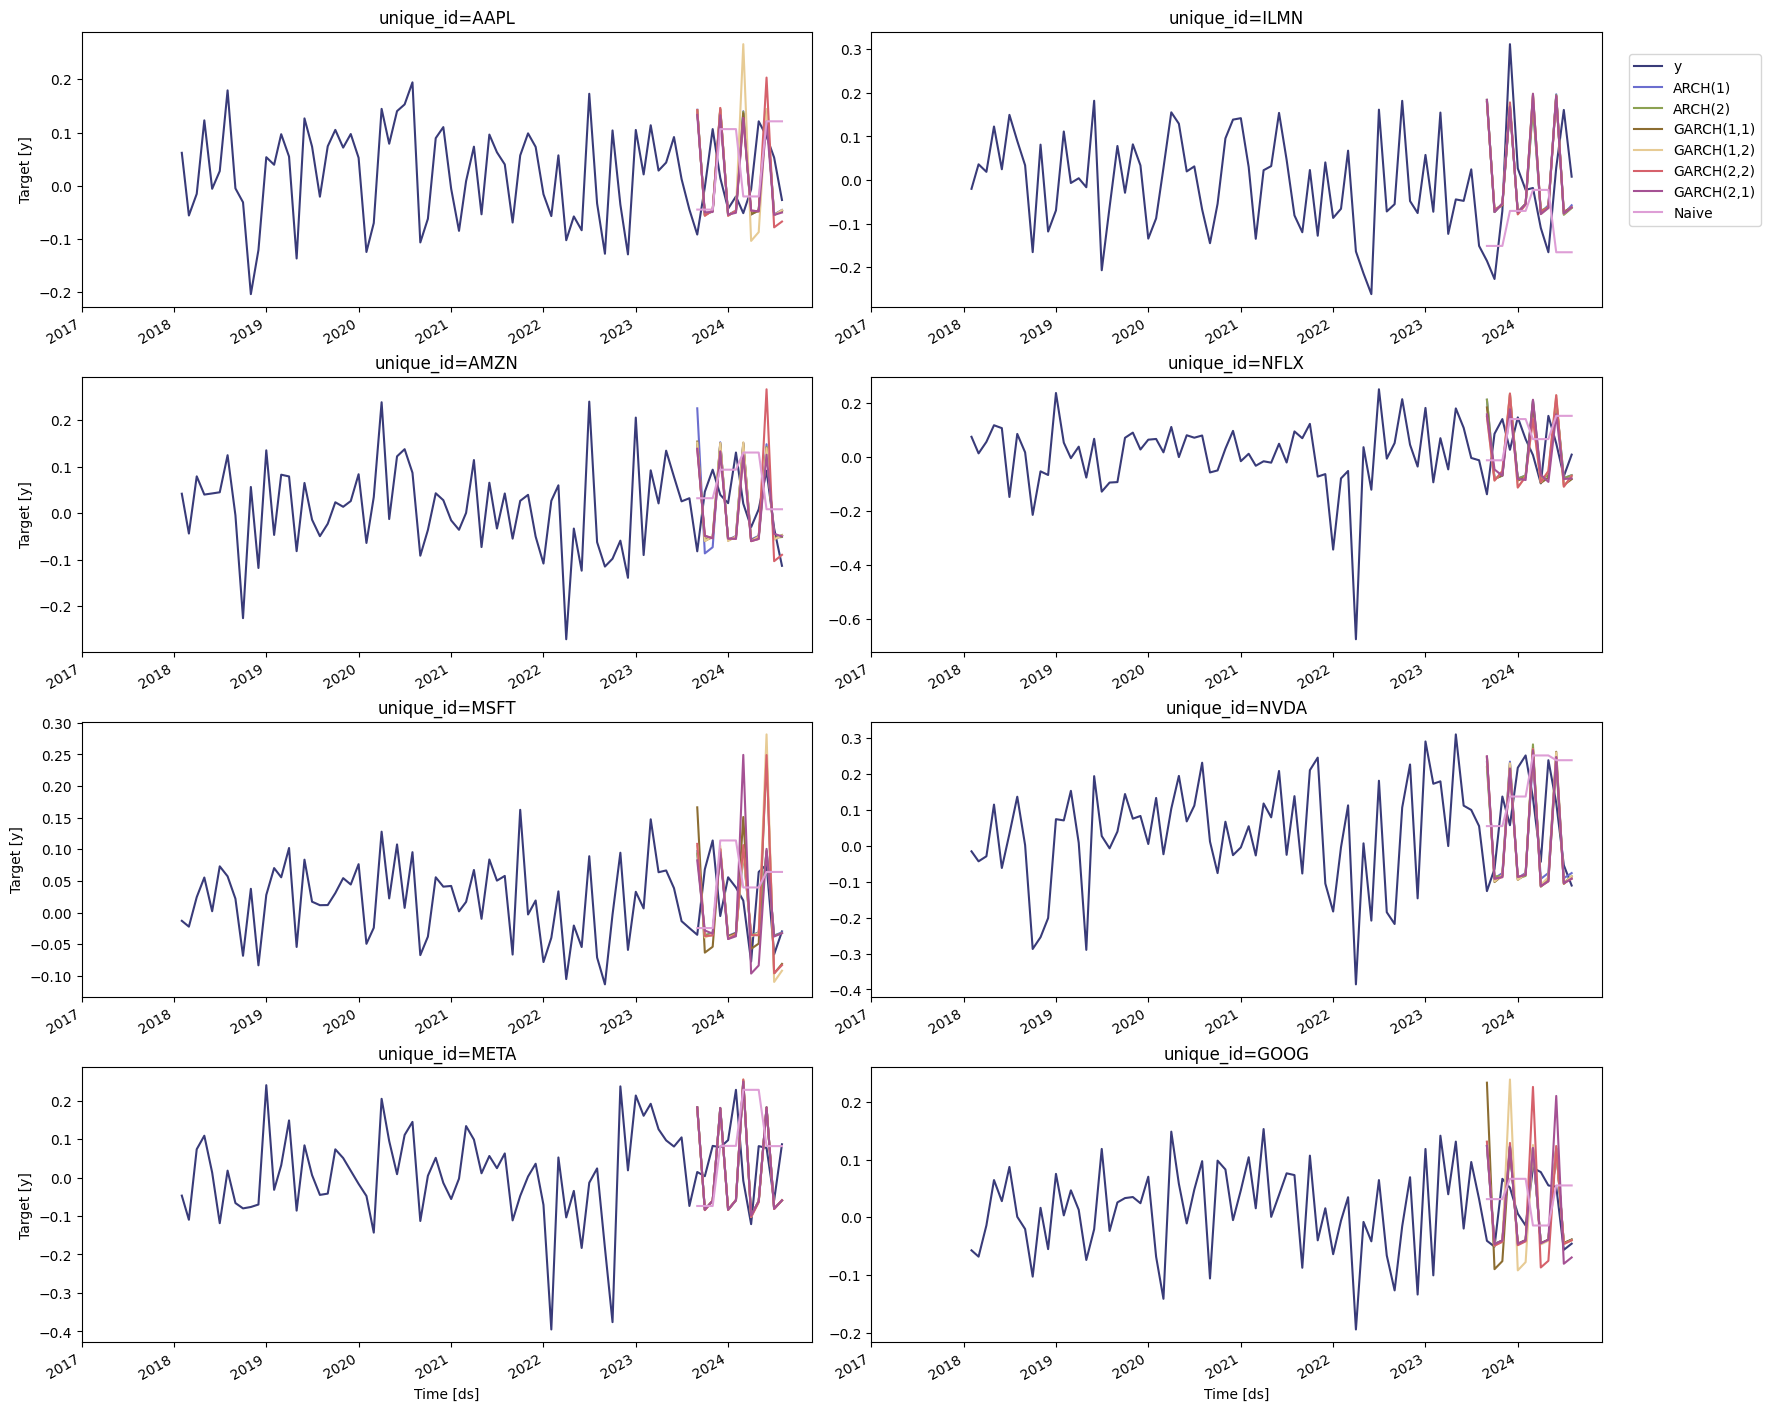

In [12]:
StatsForecast.plot(returns, crossvalidation_df.drop(['cutoff', 'actual'], axis=1))

Evaluate results

In [16]:
from datasetsforecast.losses import mae

def compute_cv_mae(crossvalidation_df):
    """Compute MAE for all models generated"""
    res = {}
    for mod in models: 
        res[mod] = mae(crossvalidation_df['actual'], crossvalidation_df[str(mod)])
    return pd.Series(res)

In [17]:
mae_cv = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(compute_cv_mae)

mae = mae_cv.groupby('unique_id').mean()
mae.style.highlight_max(color = 'lightblue', axis = 1)

/var/folders/zb/r15p7t_d62d8m2s0623s22gh0000gn/T/ipykernel_3481/508678056.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_cv = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(compute_cv_mae)


,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",Naive
unique_id,,,,,,,
AAPL,0.098831,0.098735,0.098580,0.117665,0.106715,0.094432,0.086468
AMZN,0.111360,0.099612,0.100968,0.101181,0.107037,0.093718,0.082482
GOOG,0.063431,0.063479,0.078500,0.081536,0.080373,0.073493,0.068571
ILMN,0.135209,0.135230,0.136037,0.135954,0.136083,0.136440,0.137240
META,0.138477,0.138800,0.138478,0.138565,0.138563,0.138798,0.114092
MSFT,0.076384,0.076981,0.107773,0.100581,0.096988,0.090893,0.074380
NFLX,0.163047,0.163610,0.166067,0.158805,0.158807,0.155041,0.112795
NVDA,0.172986,0.177345,0.182760,0.181571,0.179901,0.179371,0.153709
SPY,0.058058,0.057923,0.058018,0.067601,0.084854,0.057722,0.044911


In [18]:
tmp = mae.idxmax(axis=1).reset_index().rename(columns={0: "best_model"})
tmp = tmp[tmp.unique_id=='ILMN']
tmp

,unique_id,best_model
3,ILMN,Naive


Generate a forecast for the next quarter

In [19]:
levels = [95] # confidence levels for the prediction intervals 

forecasts = sf.forecast(h=3, level=levels)
forecasts = forecasts.reset_index()
forecasts.head()

/opt/anaconda3/envs/llm/lib/python3.12/site-packages/statsforecast/core.py:474: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/opt/anaconda3/envs/llm/lib/python3.12/site-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,unique_id,ds,ARCH(1),ARCH(1)-lo-95,ARCH(1)-hi-95,ARCH(2),ARCH(2)-lo-95,ARCH(2)-hi-95,"GARCH(1,1)","GARCH(1,1)-lo-95",...,"GARCH(1,2)-hi-95","GARCH(2,2)","GARCH(2,2)-lo-95","GARCH(2,2)-hi-95","GARCH(2,1)","GARCH(2,1)-lo-95","GARCH(2,1)-hi-95",Naive,Naive-lo-95,Naive-hi-95
0,AAPL,2024-09-01,0.137397,0.123374,0.151421,0.136717,0.122832,0.150602,0.134948,0.121421,...,0.148946,0.135251,0.121662,0.148839,0.133988,0.120652,0.147324,-0.026649,-0.249628,0.196331
1,AAPL,2024-10-01,-0.052989,-0.067695,-0.038284,-0.051664,-0.065643,-0.037685,-0.053370,-0.068288,...,-0.039077,-0.054452,-0.069981,-0.038924,-0.047553,-0.059396,-0.035711,-0.026649,-0.341989,0.288692
2,AAPL,2024-11-01,-0.044801,-0.058903,-0.030699,-0.046669,-0.061970,-0.031367,-0.045140,-0.059456,...,-0.030436,-0.044426,-0.058293,-0.030559,-0.048706,-0.065373,-0.032039,-0.026649,-0.412861,0.359563
3,AMZN,2024-09-01,0.147812,0.131582,0.164042,0.141859,0.126911,0.156808,0.145759,0.129977,...,0.275275,0.218744,0.183200,0.254288,0.126553,0.114656,0.138450,-0.113367,-0.381130,0.154395
4,AMZN,2024-10-01,-0.055669,-0.071898,-0.039439,-0.057468,-0.074764,-0.040172,-0.057922,-0.075493,...,-0.047578,-0.084198,-0.121326,-0.047071,-0.057417,-0.074682,-0.040152,-0.113367,-0.492040,0.265306


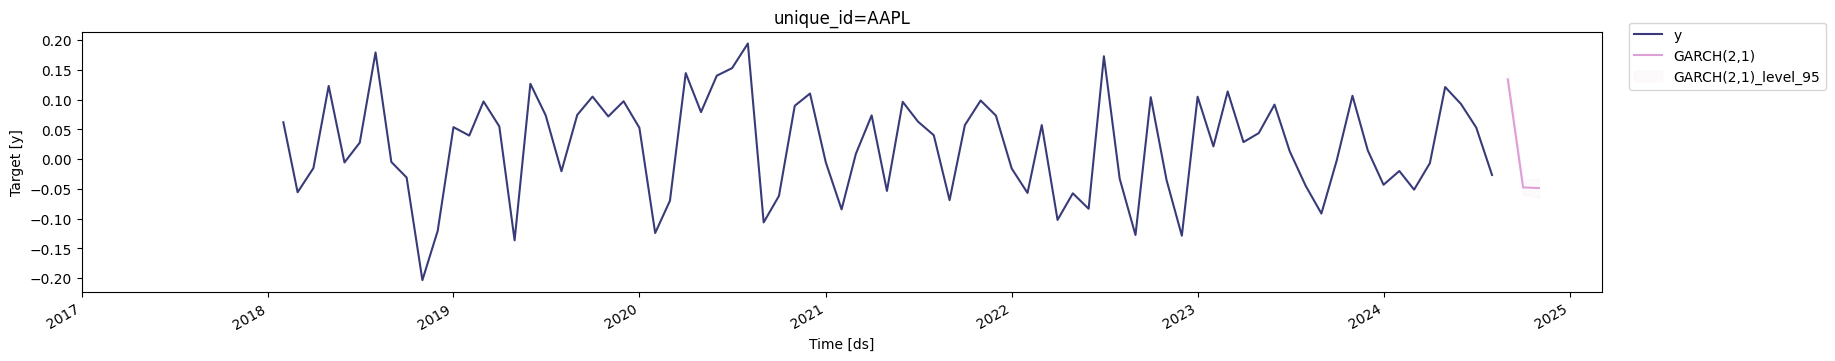

In [20]:
StatsForecast.plot(returns, forecasts, level=levels, unique_ids = ['AAPL'], models = ['GARCH(2,1)'])

In [18]:
forecasts[forecasts['unique_id'] == 'AAPL'][[col for col in forecasts[forecasts['unique_id'] == 'AAPL'].columns if "GARCH(2,1)" in col]]

,"GARCH(2,1)","GARCH(2,1)-lo-95","GARCH(2,1)-hi-95"
0,0.133986,0.120651,0.147322
1,-0.047554,-0.059396,-0.035711
2,-0.048704,-0.065370,-0.032038


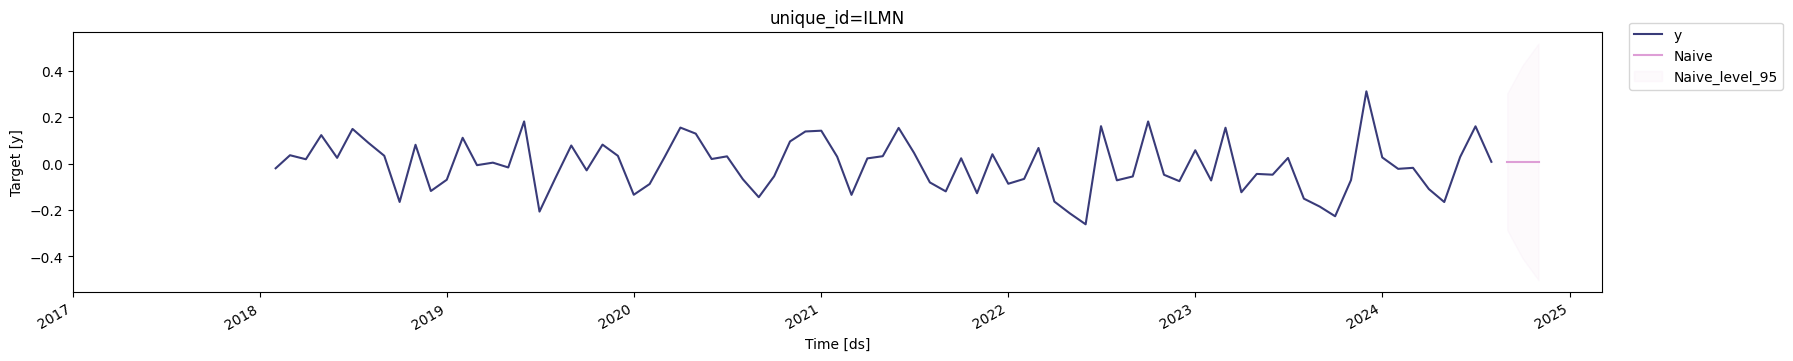

In [21]:
StatsForecast.plot(returns, forecasts, level=levels, unique_ids = ['ILMN'], models = ['Naive'])

In [22]:
tmp[tmp.unique_id=='ILMN']['best_model'].values[0]

Naive

In [23]:
tmp2 = forecasts[forecasts['unique_id'] == 'ILMN'][[col for col in forecasts[forecasts['unique_id'] == 'ILMN'].columns if "GARCH" in col]]
tmp2

,"GARCH(1,1)","GARCH(1,1)-lo-95","GARCH(1,1)-hi-95","GARCH(1,2)","GARCH(1,2)-lo-95","GARCH(1,2)-hi-95","GARCH(2,2)","GARCH(2,2)-lo-95","GARCH(2,2)-hi-95","GARCH(2,1)","GARCH(2,1)-lo-95","GARCH(2,1)-hi-95"
9,0.191891,0.164539,0.219244,0.188570,0.162156,0.214985,0.190072,0.163235,0.216908,0.190230,0.163349,0.217111
10,-0.072270,-0.099623,-0.044917,-0.071019,-0.097433,-0.044605,-0.071584,-0.098421,-0.044748,-0.068953,-0.093854,-0.044053
11,-0.062396,-0.089749,-0.035043,-0.061316,-0.087730,-0.034901,-0.061804,-0.088640,-0.034967,-0.065408,-0.095466,-0.035350


In [24]:
prices[prices['unique_id']=='ILMN'].tail(1)['y'].values[0]

123.55999755859375

In [26]:
returns = []
last_value=prices[prices['unique_id']=='ILMN'].tail(1)['y'].values[0]
for vol in [v for v in tmp2['GARCH(1,2)'].values]:
    f = np.exp(vol) * last_value
    returns.append(
        f
    )
    last_value=f

returns

[149.20143438219384, 138.97282371227664, 130.70761317478738]

In [36]:
from typing import List, Optional, Dict
from datetime import datetime
import yfinance as yf
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from statsforecast.models import (
    GARCH, 
    ARCH, 
    Naive
)
from statsforecast import StatsForecast
from datasetsforecast.losses import mae
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

models = [
    ARCH(1), 
    ARCH(2), 
    GARCH(1,1),
    GARCH(1,2),
    GARCH(2,2),
    GARCH(2,1),
    Naive()
]

def compute_cv_mae(crossvalidation_df):
    """Compute MAE for all models generated"""
    res = {}
    for mod in models: 
        res[mod] = mae(crossvalidation_df['actual'], crossvalidation_df[str(mod)])
    return pd.Series(res)

class Forecaster:
    """Runs a battery of statistical forecasting methods to forecast
    volatility of a stock"""
    
    def __init__(self):
        """Class constructor
        """
        
        
    def post__init__(
        self, 
        tickers: List[str], 
        h: int = 3
    ):
        """Pre-processes results for statistical forecasting by calculating the
        logarthmic returns of stock prices and setting it as the target variable,
        and creating a cross validiation dataframe object.
        """
        self.tickers = [ticker.upper() for ticker in tickers]
        try:
            self.df = yf.download(
                tickers, 
                start = (
                    datetime.now() - relativedelta(years=10)
                ).strftime("%Y-%m-%d"), 
                end = datetime.today().strftime("%Y-%m-%d"), 
                interval='1mo') # use monthly prices
        except Exception as e:
            raise ValueError(e)
        if len(self.tickers)>1:
            ## Prepare dataframe
            self.df = self.df.loc[:, (['Adj Close'], self.tickers)]
            self.df.columns = self.df.columns.droplevel() # drop MultiIndex
            self.df = self.df.reset_index()
            
            ## Prepare target dataframe
            self.prices = self.df.melt(id_vars = 'Date')
            self.prices = self.prices.rename(
                columns={'Date': 'ds', 'Ticker': 'unique_id', 'value': 'y'}
            )
        
        else:
            self.df['Ticker'] = self.tickers[0]
            self.df = self.df.reset_index()
            self.prices = self.df[["Date", "Ticker", "Adj Close"]]
            self.prices = self.prices.rename(
                columns={'Date': 'ds', 'Ticker': 'unique_id', 'Adj Close': 'y'}
            )
            
        self.prices = self.prices[['unique_id', 'ds', 'y']]
        self.prices['rt'] = self.prices['y'].div(self.prices.groupby('unique_id')['y'].shift(1))
        self.prices['rt'] = np.log(self.prices['rt'])
        self.returns = self.prices[['unique_id', 'ds', 'rt']]
        self.returns = self.returns.rename(columns={'rt':'y'})
    
        self.sf = StatsForecast(
            df = self.returns, 
            models = models, 
            freq = 'MS',
            n_jobs = -1)
        
        ## Prepare cross-validation dataframe
        self.crossvalidation_df = self.sf.cross_validation(
            df = self.returns,
            h = h,
            step_size = 3,
            n_windows = 4
        )
        self.crossvalidation_df = self.crossvalidation_df.reset_index()
        self.crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True)
    
    def evaluate(self):
        """Evaluates generated forecasts"""
        mae_cv = self.crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(compute_cv_mae)
        self.mae = mae_cv.groupby('unique_id').mean()
        self.best_models = self.mae.idxmax(axis=1).reset_index().rename(columns={0: "best_model"})
    
    def forecast(
        self, h: int = 3, levels: Optional[List[int]] = [95]
    ):
        """Generates a forecast for the next h periods

        Args:
            h (int, optional): Forecasting horizon (number of periods to forecast). Defaults to 3.
            levels (Optional[List[int]], optional): Confidence level for prediction intervals. Defaults to [80,95].
        """
        self.forecasts = self.sf.forecast(h=h, level=levels)
        self.forecasts = self.forecasts.reset_index()
    
    def forecast_ticker(self, ticker: Optional[str] = None) -> Dict[str, List[float]]:
        """Returns a forecast for a ticker of interest

        Args:
            ticker (str): Stock ticker of interest. If this is none, we'll just compute the
            forecasts for all the tickers
        """
        if ticker:
            ticker = ticker.upper()
            filtered = self.forecasts[self.forecasts['unique_id'] == ticker]
            best_model = self.best_models[self.best_models['unique_id']==ticker]['best_model'].values[0]
            df = filtered[[col for col in filtered.columns if str(best_model) in col]]
            
            ## Get last price
            last_price = self.prices[self.prices['unique_id']==ticker].tail(1)['y'].values[0]
            
            return self.compute_forecast(
                last_price = last_price,
                df = df,
                ticker = ticker
            )
        else:
            returns = dict()
            for ticker in self.tickers:
                filtered = self.forecasts[self.forecasts['unique_id'] == ticker]
                best_model = self.best_models[self.best_models['unique_id']==ticker]['best_model'].values[0]
                df = filtered[[col for col in filtered.columns if str(best_model) in col]]
                
                ## Get last price
                last_price = self.prices[self.prices['unique_id']==ticker].tail(1)['y'].values[0]
                
                returns[ticker] = self.compute_forecast(
                    last_price = last_price,
                    df = df,
                    ticker = ticker
                )
        
        #To-Do: Merge results
            return returns
    
    def show_max(self):
        """Helper function to visually show the best forecasting model"""
        self.mae.style.highlight_max(color = 'lightblue', axis = 1)
    
    @staticmethod
    def compute_forecast(
        last_price: float, df: pd.DataFrame, ticker: str) -> float:
        """Static method to compute forecasted price from forecasted log return values
        """
        returns = defaultdict(list)
        last_value=last_price
        for col in df.columns:
            for vol in [v for v in df[col].values]:
                f = np.exp(vol) * last_value
                returns[col].append(
                    f
                )
                last_value=f

        return returns
    
    def plot_post_init(self):
        """Plots forecast against actual test results.
        For debugging purposes"""
        try:
            StatsForecast.plot(
                self.returns, 
                self.crossvalidation_df.drop(['cutoff', 'actual'],
                    axis=1))
        except:
            self.post__init__()
            StatsForecast.plot(
                self.returns, 
                self.crossvalidation_df.drop(['cutoff', 'actual'],
                    axis=1))
    
    def __call__(
        self,
        tickers: List[str],
        ticker: Optional[str] = None,  
        h: Optional[int] = 3,
        levels: Optional[List[int]] = [80, 95]
    ) -> Dict[str, List[float]]:
        """Super function to tie all the methods together.

        Args:
            ticker (Optional[str], optional): _description_. Defaults to None.
            h (Optional[int], optional): _description_. Defaults to 3.
            levels (Optional[List[int]], optional): _description_. Defaults to [95].

        Returns:
            Dictionary of forecasts
        """
        self.post__init__(tickers = tickers, h=h)
        self.evaluate()
        self.forecast(h=h, levels=levels)
        return self.forecast_ticker(ticker=ticker)

In [37]:
forecaster = Forecaster()

In [38]:
results = forecaster(tickers=["ilmn", "aapl", "nvda","goog", "meta"], ticker="ilmn")

[*********************100%%**********************]  5 of 5 completed


In [30]:
tmp = pd.DataFrame(results)
mapper = dict()
for col in tmp.columns:
    if "lo" in col:
        if "95" in col:
            mapper[col] = col.split("-")[0] + "_95%_Confidence_Interval_Low"
        else:
            mapper[col] = col.split("-")[0] + "_80%_Confidence_Interval_Low"
    elif "hi" in col:
        if "95" in col:
            mapper[col] = col.split("-")[0] + "_95%_Confidence_Interval_High"
        else:
            mapper[col] = col.split("-")[0] + "_80%_Confidence_Interval_High"
tmp.rename(columns = mapper, inplace=True)
tmp

,"GARCH(1,2)","GARCH(1,2)_95%_Confidence_Interval_Low","GARCH(1,2)_80%_Confidence_Interval_Low","GARCH(1,2)_80%_Confidence_Interval_High","GARCH(1,2)_95%_Confidence_Interval_High"
0,150.034388,153.819234,149.984697,154.874754,174.627907
1,138.449560,137.222162,135.376821,146.111644,166.686952
2,130.273665,125.801061,125.232606,139.843346,160.979897


In [31]:
StatsForecast.plot(
    forecaster.returns, 
    forecaster.forecasts, 
    level=[80, 95], 
    unique_ids = ['ILMN'], 
    models = ['GARCH(1,2)'],
    engine = "plotly")

In [40]:
forecaster.best_models

,unique_id,best_model
0,AAPL,"GARCH(1,2)"
1,GOOG,"GARCH(1,1)"
2,ILMN,"GARCH(1,2)"
3,META,"GARCH(1,1)"
4,NVDA,"GARCH(2,2)"


In [108]:
forecaster2 = Forecaster()

In [109]:
forecaster2(tickers=["ilmn"])

[*********************100%%**********************]  1 of 1 completed


{'ILMN': defaultdict(list,
             {'GARCH(1,2)': [149.20143438219384,
               138.97282371227664,
               130.70761317478738],
              'GARCH(1,2)-lo-95': [153.71788698360507,
               139.44717402874693,
               127.73477624511509],
              'GARCH(1,2)-hi-95': [158.37106957668846,
               151.4622170763708,
               146.26717595824195]})}

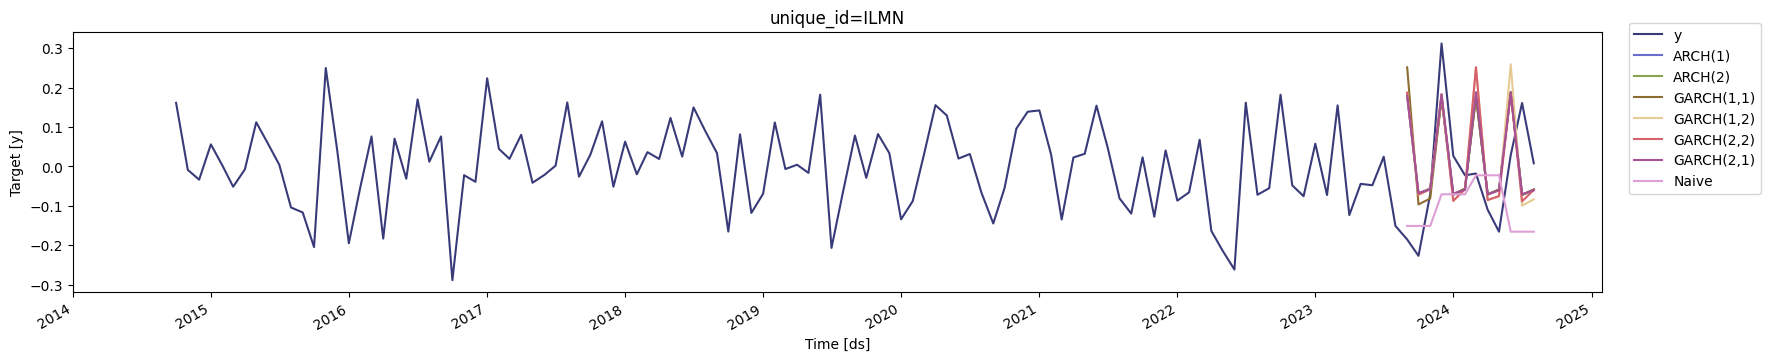

In [110]:
StatsForecast.plot(
    forecaster2.returns, 
    forecaster2.crossvalidation_df.drop(['cutoff', 'actual'],
        axis=1))